In [283]:
#import conda
import shap
import numpy as np
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix
import itertools
import nbimporter
from important_methods import *

In [316]:
def plot_confusion_matrix(cm, classes=[],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, figsize_val=6.5):

    fig=plt.figure(figsize=(figsize_val,figsize_val))
    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [317]:
def generate_synthetic_dataset(num_samples, 
                               num_features, 
                               num_important_features, 
                               test_size=0.25, 
                               random_seed=None, 
                               noise=0.4):
    if random_seed is not None:
        np.random.seed(random_seed)

    # Generate random values for all features within a limited range
    dataset = np.random.uniform(0, 1, size=(num_samples, num_features))
    
    # Select important features
    important_features = np.random.choice(num_features, num_important_features, replace=False)
    
    # Assign random weights to the important features
    weights = np.random.uniform(0.5, 1.0, size=(num_samples,num_important_features))
    
    # **Apply weights to the important features in the dataset**
    dataset[:, important_features] = weights  # This scales the important features by their weights

    # Compute the y_linear combination of important features (now weights are already applied)
    y = dataset[:, important_features].sum(axis=1)
    
    # Add Gaussian noise to simulate real-world imperfections
    y += np.random.normal(0, noise, size=num_samples)
    
    # Normalize y to the range [0, 1]
    y_min, y_max = y.min(), y.max()
    y = (y - y_min) / (y_max - y_min)
    
    
    # Split dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        dataset, y, test_size=test_size, random_state=random_seed
    )

    # Create binary target variables based on a threshold of 0.5
    y_train_d = (y_train >= 0.5).astype(int)
    y_test_d = (y_test >= 0.5).astype(int)
    
    return X_train, X_test, y_train, y_test, important_features, y_train_d, y_test_d


In [318]:
X_train, X_test, y_train, y_test, important_features, y_train_d, y_test_d  = generate_synthetic_dataset(num_samples=10000, 
                                                                                                        num_features=8, 
                                                                                                        num_important_features=1, 
                                                                                                        random_seed=42)
print(important_features)

# Train the model
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train_d), 100)

# Evaluate the model
y_pred = model.predict(xgboost.DMatrix(X_test, label=y_test_d))
predictions = np.array([round(value) for value in y_pred])
# evaluate predictions
accuracy = accuracy_score(y_test_d, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_test)


[0]
Accuracy: 60.20%


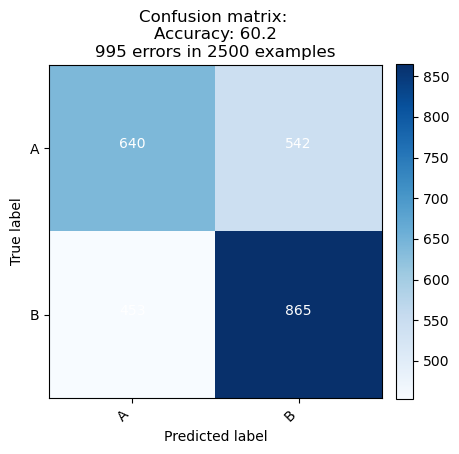

In [319]:
M = confusion_matrix(y_test_d, predictions)
    
# Calculate number of errors and create the description strings
a = "%d errors in %d examples" % (np.sum(y_test_d != predictions), y_test_d.shape[0])
b = "Accuracy: " + str(round(100 - np.sum(y_test_d != predictions) * 100 / y_test_d.shape[0], 2))

figsize_val = 4.5  # Customize the size if needed
classes_in = ['A', 'B']  # Adjust the class names if necessary
plot_confusion_matrix(M, classes=classes_in, figsize_val=figsize_val, title='Confusion matrix: ' + '\n' + str(b) + '\n' + str(a))

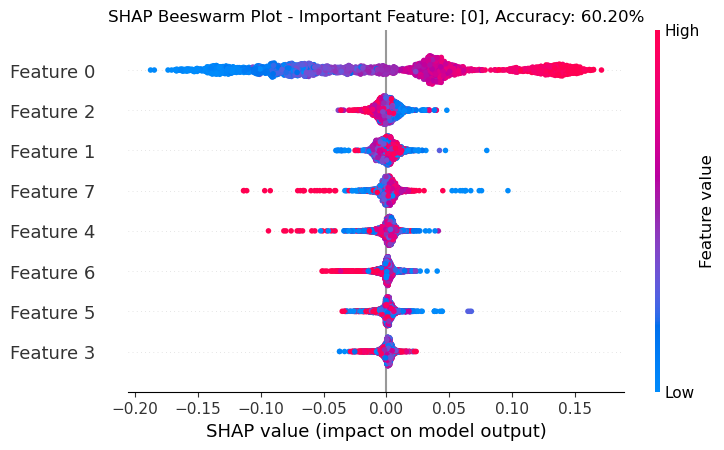

In [288]:
# Create a beeswarm plot with the important feature and accuracy in the title
plt.title(f"SHAP Beeswarm Plot - Important Feature: {important_features}, Accuracy: {accuracy * 100:.2f}%")
shap.plots.beeswarm(shap_values)
plt.show()

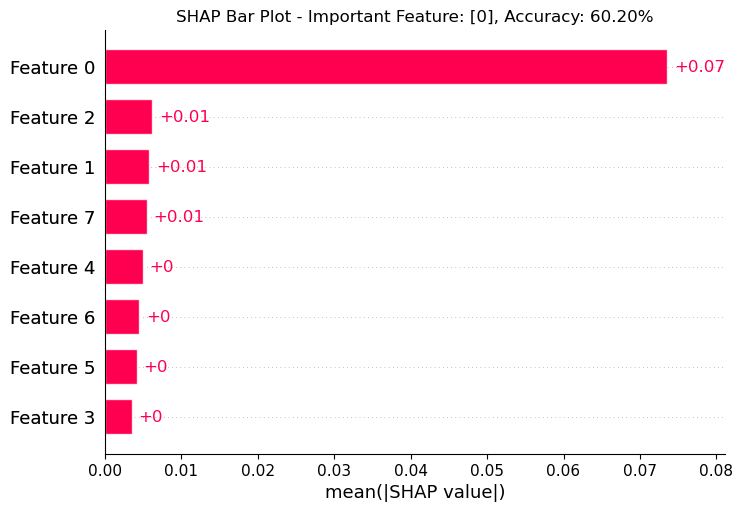

In [289]:
# Create a bar plot with the important feature and accuracy in the title
plt.title(f"SHAP Bar Plot - Important Feature: {important_features}, Accuracy: {accuracy * 100:.2f}%")
shap.plots.bar(shap_values)
plt.show()

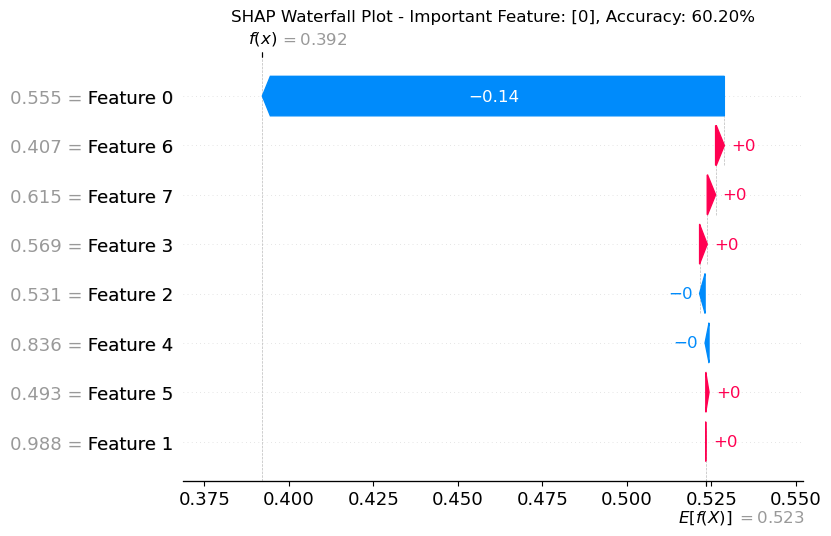

In [290]:
# Create a waterfall plot with the important feature and accuracy in the title
plt.title(f"SHAP Waterfall Plot - Important Feature: {important_features}, Accuracy: {accuracy * 100:.2f}%")
shap.plots.waterfall(shap_values[1])
plt.show()

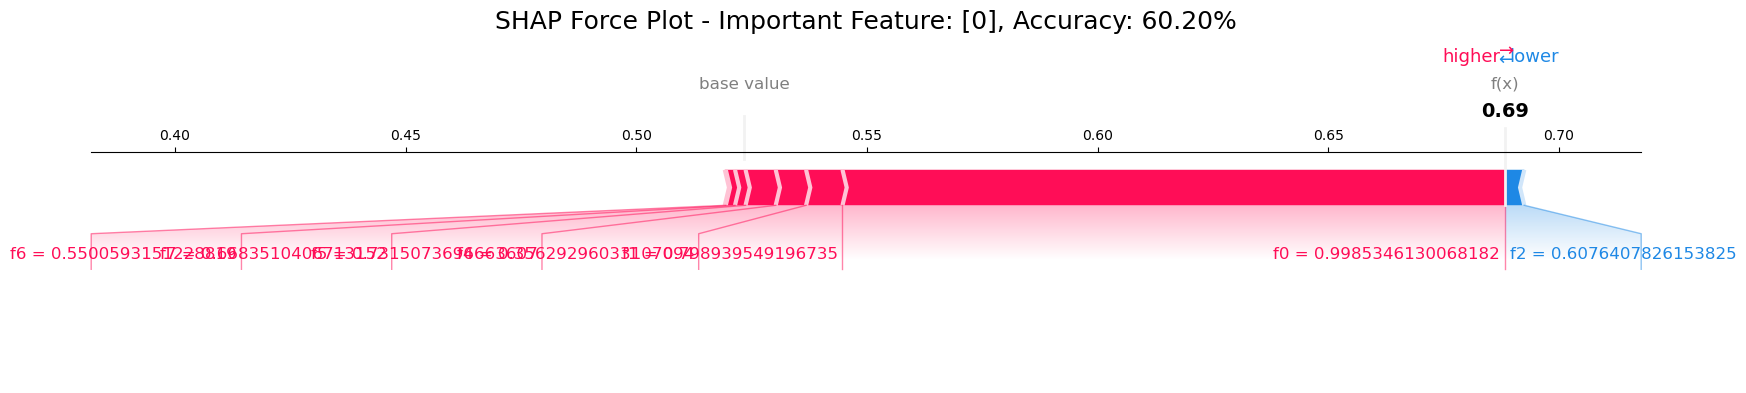

In [291]:
# Create a force plot with the important feature and accuracy in the title
shap.plots.force(shap_values[0], matplotlib=True, feature_names=['f0', 'f1', 'f2', 'f3','f4', 'f5', 'f6', 'f7'], show=False)
plt.title(f"SHAP Force Plot - Important Feature: {important_features}, Accuracy: {accuracy * 100:.2f}%", y=1.5, fontsize=18)
plt.show()

In [292]:
# Initialize JavaScript visualization in Jupyter (for interactive plots)
shap.plots.initjs()

# Display a custom centered HTML title above the force plot
display(HTML(f"<h3 style='text-align: center;'>SHAP Force Plot - Important Feature: {important_features}, Accuracy: {accuracy * 100:.2f}%</h3>"))

# Visualize all the training set predictions with a force plot
shap.plots.force(shap_values[:100], feature_names=['f0', 'f1', 'f2', 'f3','f4', 'f5', 'f6', 'f7'])

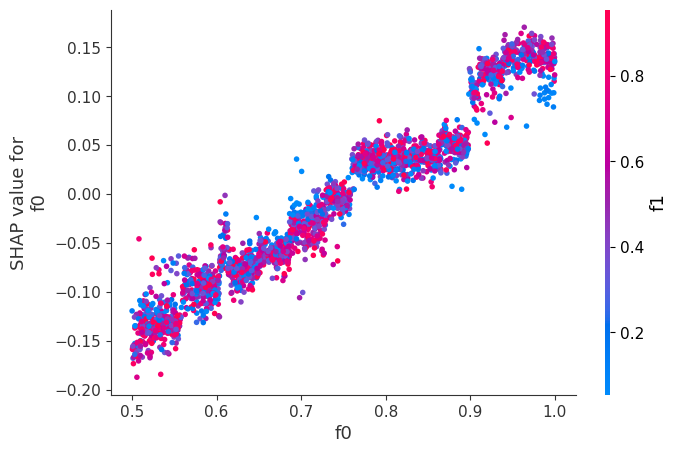

In [293]:
shap.dependence_plot(0, shap_values.values, X_test, feature_names=['f0', 'f1', 'f2', 'f3','f4', 'f5', 'f6', 'f7'])
plt.show()

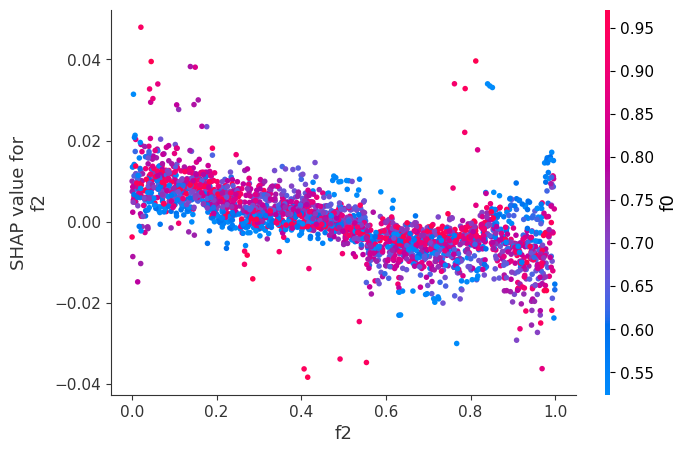

In [294]:
shap.dependence_plot(2, shap_values.values, X_test, feature_names=['f0', 'f1', 'f2', 'f3','f4', 'f5', 'f6', 'f7'])
plt.show()

In [295]:
X_train, X_test, y_train, y_test, important_features, y_train_d, y_test_d  = generate_synthetic_dataset(num_samples=10000, 
                                                                                                        num_features=8, 
                                                                                                        num_important_features=2, 
                                                                                                        random_seed=42)
print(important_features)

# Train the model
model = xgboost.train({"learning_rate": 0.01, 'objective': 'binary:logistic'}, xgboost.DMatrix(X_train, label=y_train), 100)

# Evaluate the model
y_pred = model.predict(xgboost.DMatrix(X_test, label=y_test_d))
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test_d, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_test)



[0 6]
Accuracy: 64.96%


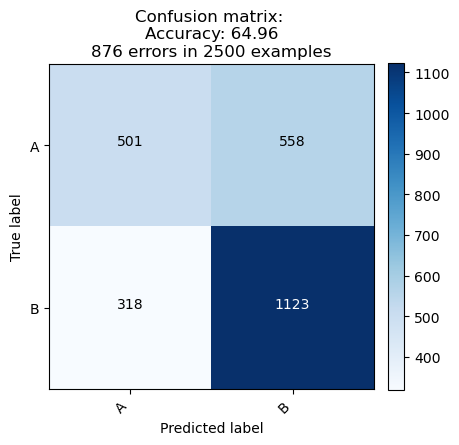

In [296]:
M = confusion_matrix(y_test_d, predictions)
    
# Calculate number of errors and create the description strings
a = "%d errors in %d examples" % (np.sum(y_test_d != predictions), y_test_d.shape[0])
b = "Accuracy: " + str(round(100 - np.sum(y_test_d != predictions) * 100 / y_test_d.shape[0], 2))

figsize_val = 4.5  # Customize the size if needed
classes_in = ['A', 'B']  # Adjust the class names if necessary
plot_confusion_matrix(M, classes=classes_in, figsize_val=figsize_val, title='Confusion matrix: ' + '\n' + str(b) + '\n' + str(a))

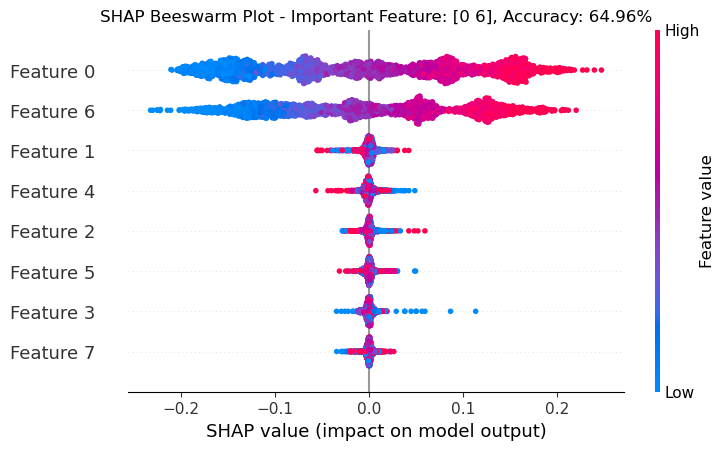

In [297]:
# Create a beeswarm plot with the important feature and accuracy in the title
plt.title(f"SHAP Beeswarm Plot - Important Feature: {important_features}, Accuracy: {accuracy * 100:.2f}%")
shap.plots.beeswarm(shap_values)
plt.show()

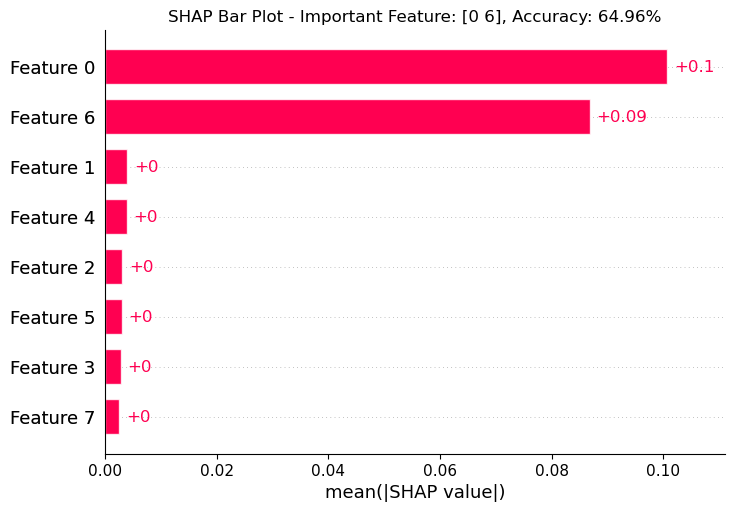

In [298]:
# Create a bar plot with the important feature and accuracy in the title
plt.title(f"SHAP Bar Plot - Important Feature: {important_features}, Accuracy: {accuracy * 100:.2f}%")
shap.plots.bar(shap_values)
plt.show()

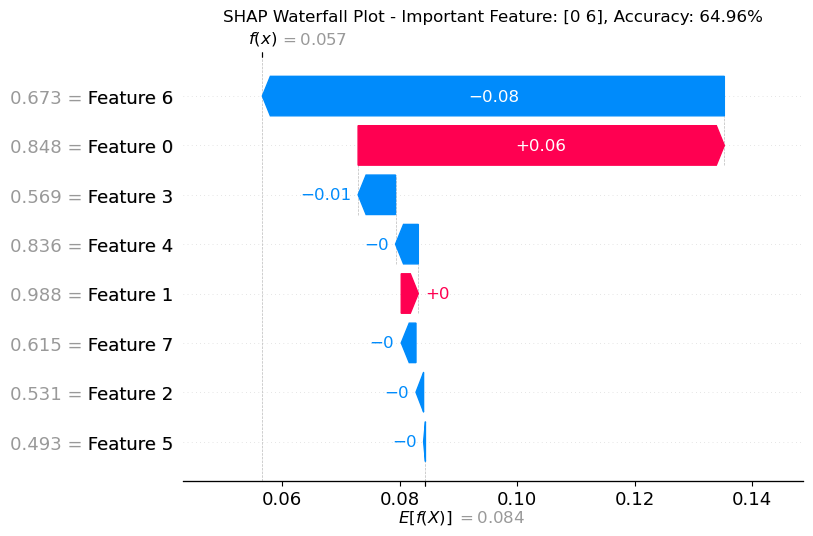

In [299]:
# Create a waterfall plot with the important feature and accuracy in the title
plt.title(f"SHAP Waterfall Plot - Important Feature: {important_features}, Accuracy: {accuracy * 100:.2f}%")
shap.plots.waterfall(shap_values[1])
plt.show()

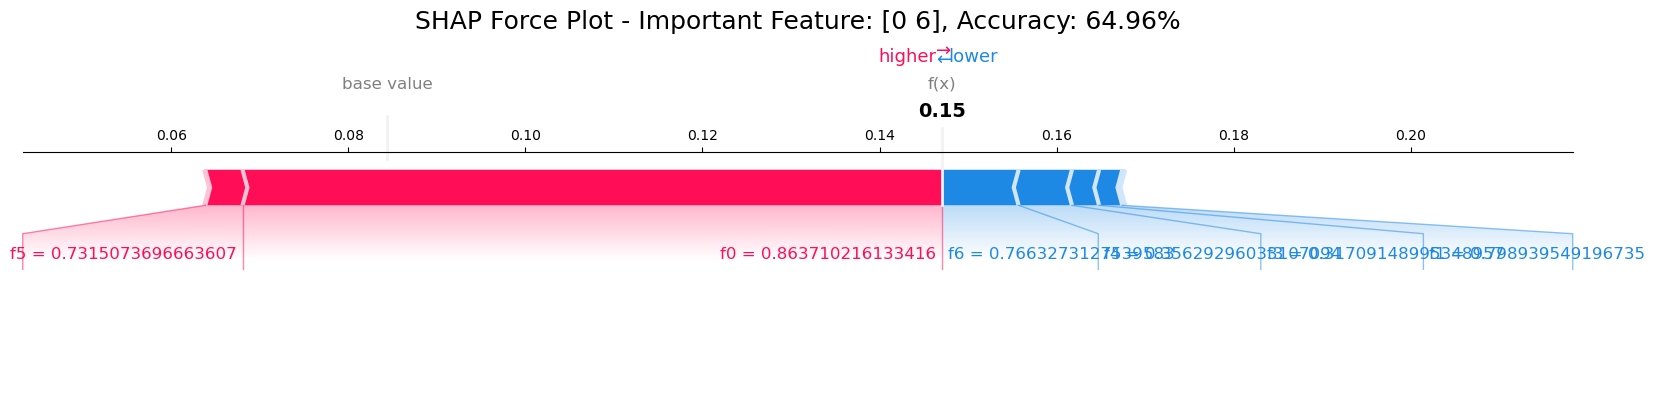

In [300]:
# Create a force plot with the important feature and accuracy in the title
shap.plots.force(shap_values[0], matplotlib=True, feature_names=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'], show=False)
plt.title(f"SHAP Force Plot - Important Feature: {important_features}, Accuracy: {accuracy * 100:.2f}%", y=1.5, fontsize=18)
plt.show()

In [301]:
# Initialize JavaScript visualization in Jupyter (for interactive plots)
shap.plots.initjs()

# Display a custom centered HTML title above the force plot
display(HTML(f"<h3 style='text-align: center;'>SHAP Force Plot - Important Feature: {important_features}, Accuracy: {accuracy * 100:.2f}%</h3>"))

# Visualize all the training set predictions with a force plot
shap.plots.force(shap_values[:100], feature_names=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'])

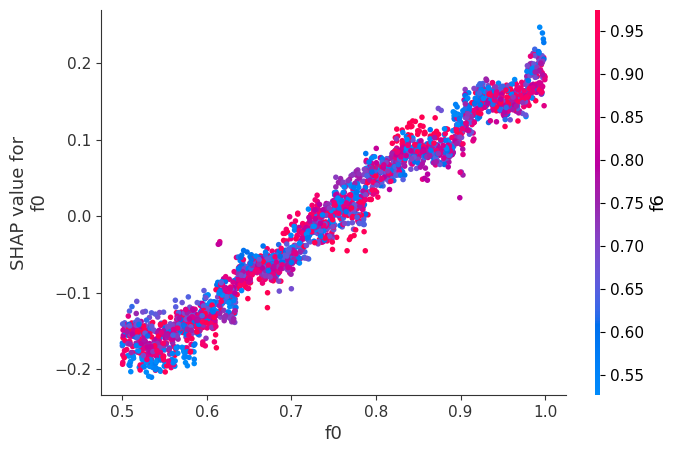

In [302]:
shap.dependence_plot(0, shap_values.values, X_test, feature_names=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'])
plt.show()

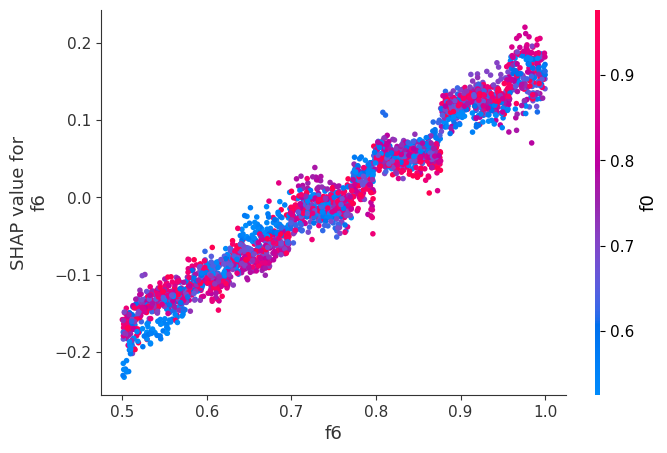

In [303]:
shap.dependence_plot(6, shap_values.values, X_test, feature_names=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'])
plt.show()

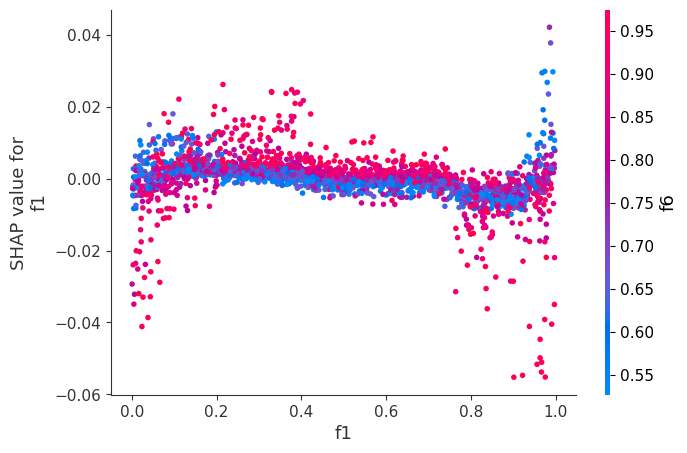

In [304]:
shap.dependence_plot(1, shap_values.values, X_test, feature_names=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'])
plt.show()

In [305]:
X_train, X_test, y_train, y_test, important_features, y_train_d, y_test_d  = generate_synthetic_dataset(num_samples=10000, 
                                                                                                        num_features=8, 
                                                                                                        num_important_features=3, 
                                                                                                        random_seed=42)
print(important_features)

# Train the model
model = xgboost.train({"learning_rate": 0.01, 'objective': 'binary:logistic'}, xgboost.DMatrix(X_train, label=y_train), 1000)

# Evaluate the model
y_pred = model.predict(xgboost.DMatrix(X_test, label=y_test_d))
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test_d, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_test)



[0 6 7]
Accuracy: 68.20%


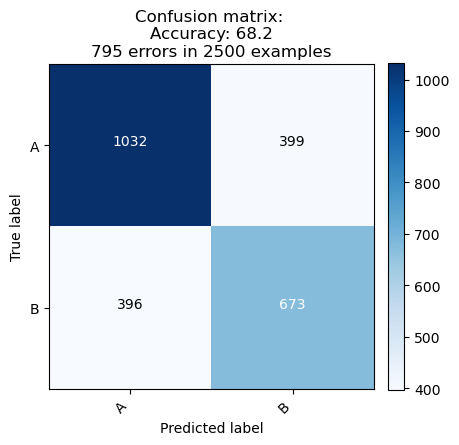

In [306]:
M = confusion_matrix(y_test_d, predictions)
    
# Calculate number of errors and create the description strings
a = "%d errors in %d examples" % (np.sum(y_test_d != predictions), y_test_d.shape[0])
b = "Accuracy: " + str(round(100 - np.sum(y_test_d != predictions) * 100 / y_test_d.shape[0], 2))

figsize_val = 4.5  # Customize the size if needed
classes_in = ['A', 'B']  # Adjust the class names if necessary
plot_confusion_matrix(M, classes=classes_in, figsize_val=figsize_val, title='Confusion matrix: ' + '\n' + str(b) + '\n' + str(a))

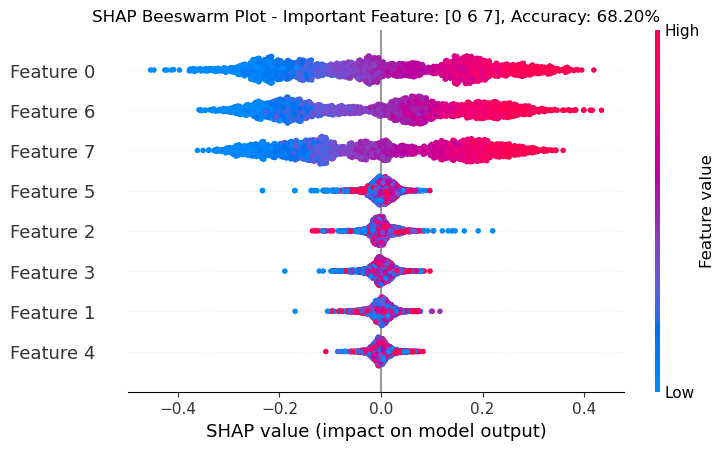

In [307]:
# Create a beeswarm plot with the important feature and accuracy in the title
plt.title(f"SHAP Beeswarm Plot - Important Feature: {important_features}, Accuracy: {accuracy * 100:.2f}%")
shap.plots.beeswarm(shap_values)
plt.show()

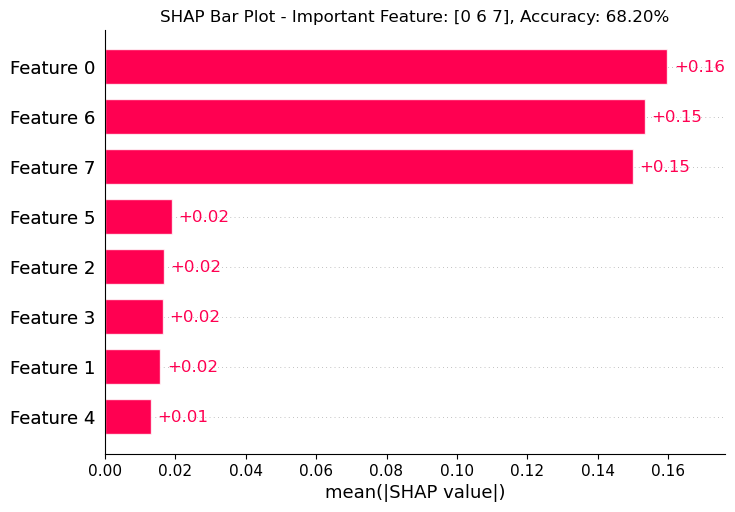

In [308]:
# Create a bar plot with the important feature and accuracy in the title
plt.title(f"SHAP Bar Plot - Important Feature: {important_features}, Accuracy: {accuracy * 100:.2f}%")
shap.plots.bar(shap_values)
plt.show()

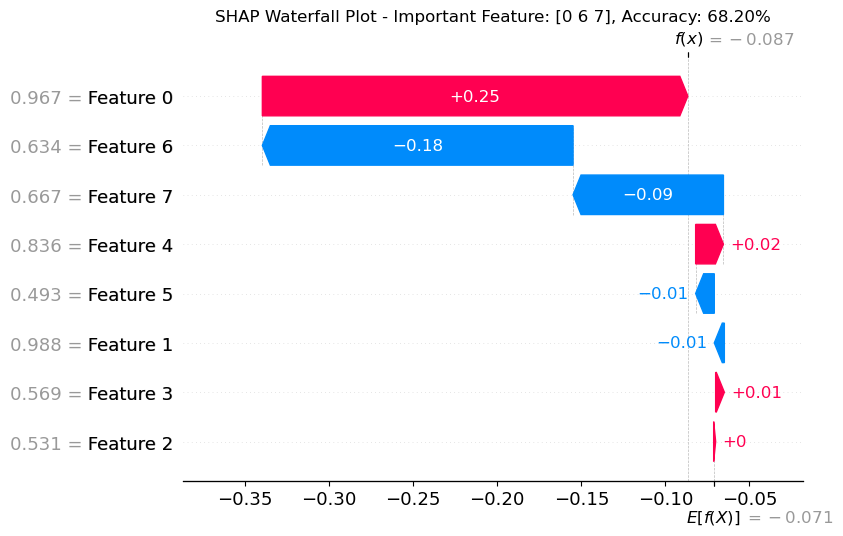

In [309]:
# Create a waterfall plot with the important feature and accuracy in the title
plt.title(f"SHAP Waterfall Plot - Important Feature: {important_features}, Accuracy: {accuracy * 100:.2f}%")
shap.plots.waterfall(shap_values[1])
plt.show()

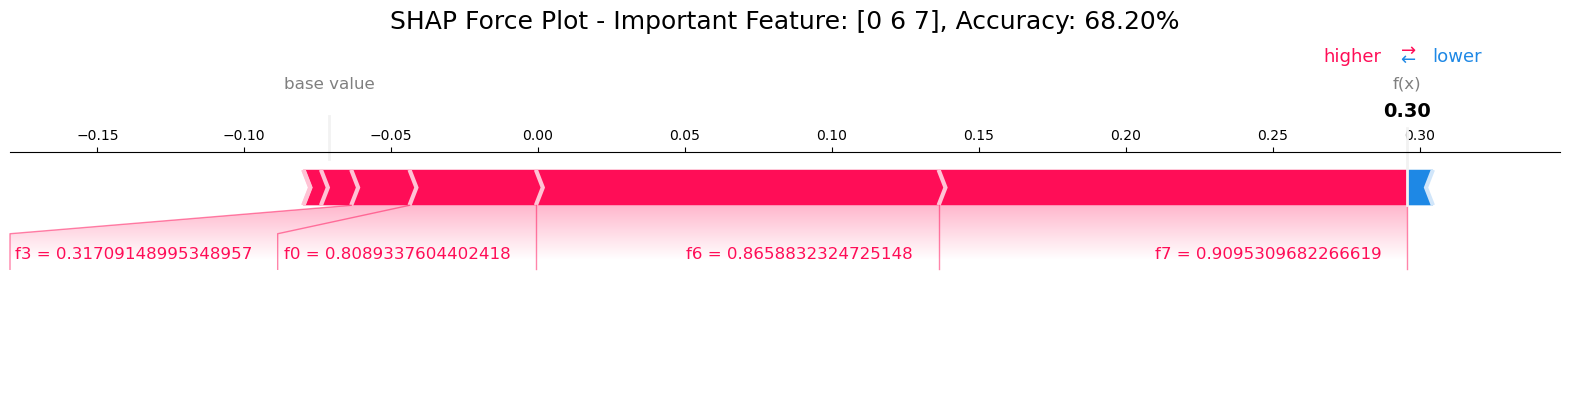

In [310]:
# Create a force plot with the important feature and accuracy in the title
shap.plots.force(shap_values[0], matplotlib=True, feature_names=['f0', 'f1', 'f2', 'f3','f4', 'f5', 'f6', 'f7'], show=False)
plt.title(f"SHAP Force Plot - Important Feature: {important_features}, Accuracy: {accuracy * 100:.2f}%", y=1.5, fontsize=18)
plt.show()

In [311]:
# Initialize JavaScript visualization in Jupyter (for interactive plots)
shap.plots.initjs()

# Display a custom centered HTML title above the force plot
display(HTML(f"<h3 style='text-align: center;'>SHAP Force Plot - Important Feature: {important_features}, Accuracy: {accuracy * 100:.2f}%</h3>"))

# Visualize all the training set predictions with a force plot
shap.plots.force(shap_values[:100], feature_names=['f0', 'f1', 'f2', 'f3','f4', 'f5', 'f6', 'f7'])

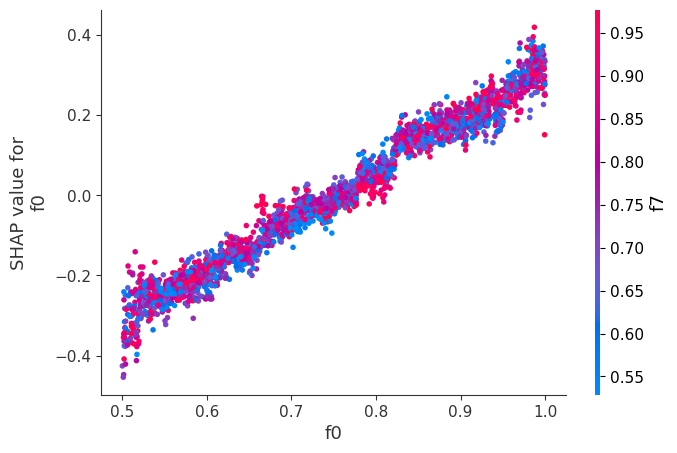

In [312]:
shap.dependence_plot(0, shap_values.values, X_test, feature_names=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'])
plt.show()

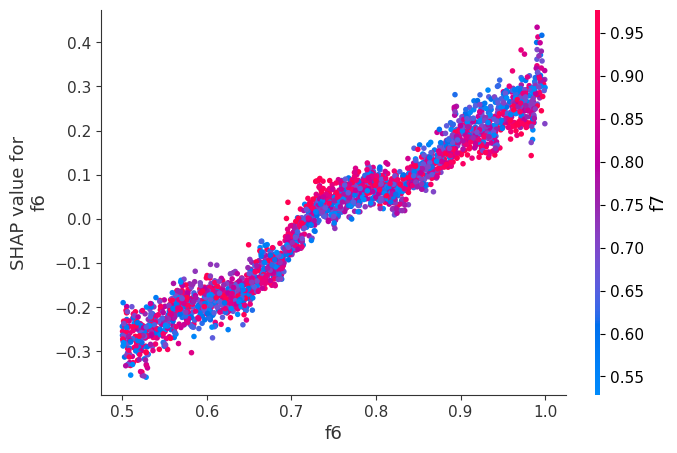

In [313]:
shap.dependence_plot(6, shap_values.values, X_test, feature_names=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'])
plt.show()

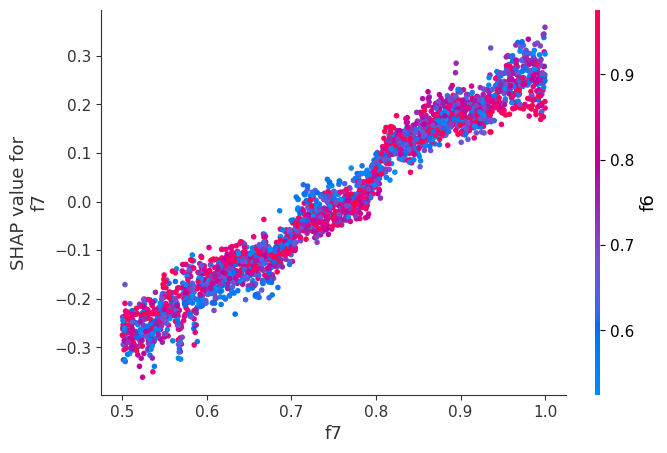

In [314]:
shap.dependence_plot(7, shap_values.values, X_test, feature_names=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'])
plt.show()

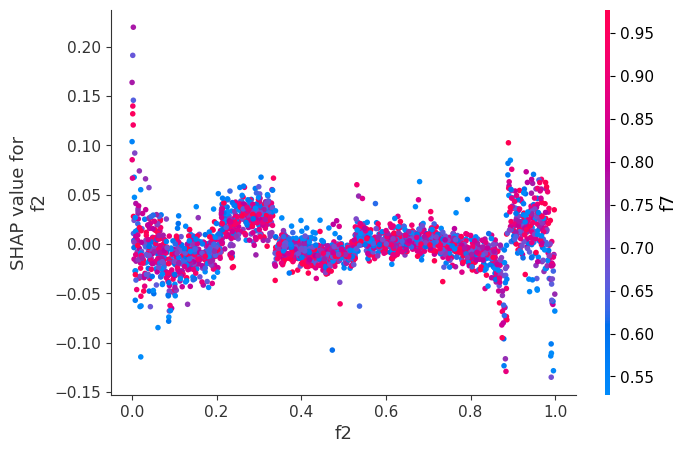

In [315]:
shap.dependence_plot(2, shap_values.values, X_test, feature_names=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'])
plt.show()